In [1]:
# this notebook takes the data from the database and prepares it for ML prediction

In [2]:
import sqlite3
import pandas as pd

# Connect to the SQLite database
db_path = "../youbike_data.db"
conn = sqlite3.connect(db_path)

# Define the start timestamp
start_time = "2025-02-13 00:00:00"

# Query for YouBike status data with filtering
youbike_query = f"""
SELECT 
    sno AS youbike_station_id,
    mday AS timestamp,
    available_rent_bikes,
    available_return_bikes
FROM youbike_status
WHERE mday >= '{start_time}'
"""

# Query for weather data with filtering
weather_query = f"""
SELECT 
    station_name AS weather_station_name,
    observe_time AS timestamp,
    temperature,
    weather,
    wind_speed,
    humidity,
    pressure,
    rainfall
FROM weather
WHERE observe_time >= '{start_time}'
"""

# Load the data into separate DataFrames
df_youbike = pd.read_sql_query(youbike_query, conn)
df_weather = pd.read_sql_query(weather_query, conn)

# Calculate YouBike capacity
df_youbike['capacity'] = df_youbike['available_rent_bikes'] + df_youbike['available_return_bikes']

# Close the connection
conn.close()

# Display shapes for sanity check
print(f"YouBike Data Shape: {df_youbike.shape}")
print(f"Weather Data Shape: {df_weather.shape}")

# Display the first few rows of the data for verification
print(df_youbike.head())
print(df_weather.head())

YouBike Data Shape: (7590425, 5)
Weather Data Shape: (94440, 8)
  youbike_station_id            timestamp  available_rent_bikes  \
0          500101001  2025-02-13 00:04:33                     9   
1          500101002  2025-02-13 00:04:33                    18   
2          500101003  2025-02-13 00:04:33                     9   
3          500101004  2025-02-13 00:04:33                     9   
4          500101005  2025-02-13 00:04:33                     9   

   available_return_bikes  capacity  
0                      19        28  
1                       3        21  
2                       7        16  
3                       2        11  
4                       7        16  
  weather_station_name            timestamp  temperature           weather  \
0                 Anpu  2025-02-13 00:04:35         11.8  CLOUDY WITH RAIN   
1               Taipei  2025-02-13 00:04:35         17.1  CLOUDY WITH RAIN   
2         Yangmingshan  2025-02-13 00:04:36         13.1  CLOUDY WITH R

In [3]:
df_youbike.loc[124]
# station with max capacity is 500101181

youbike_station_id                  500101181
timestamp                 2025-02-13 00:04:33
available_rent_bikes                       58
available_return_bikes                     41
capacity                                   99
Name: 124, dtype: object

In [4]:
df_youbike["capacity"].idxmax()

124

In [5]:
# df_weather.iloc[970]
df_weather.head(971)

,weather_station_name,timestamp,temperature,weather,wind_speed,humidity,pressure,rainfall
0,Anpu,2025-02-13 00:04:35,11.8,CLOUDY WITH RAIN,NaN,NaN,NaN,NaN
1,Taipei,2025-02-13 00:04:35,17.1,CLOUDY WITH RAIN,NaN,NaN,NaN,NaN
2,Yangmingshan,2025-02-13 00:04:36,13.1,CLOUDY WITH RAIN,NaN,NaN,NaN,NaN
3,NTU,2025-02-13 00:04:36,17.3,CLOUDY WITH RAIN,NaN,NaN,NaN,NaN
4,PCCU,2025-02-13 00:04:36,14.3,CLOUDY WITH RAIN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
966,Freeway No. 3 - CCTV – A005K,2025-02-13 08:27:55,13.0,CLOUDY WITH RAIN,NaN,NaN,NaN,NaN
967,Da'an Forest Park,2025-02-13 08:27:56,13.2,CLOUDY WITH RAIN,NaN,NaN,NaN,NaN
968,Agriculture Guandu Station,2025-02-13 08:27:56,13.6,CLOUDY,NaN,NaN,NaN,NaN
969,Anpu,2025-02-13 08:37:57,7.4,CLOUDY WITH RAIN,NaN,NaN,NaN,NaN


In [6]:
df_youbike

,youbike_station_id,timestamp,available_rent_bikes,available_return_bikes,capacity
0,500101001,2025-02-13 00:04:33,9,19,28
1,500101002,2025-02-13 00:04:33,18,3,21
2,500101003,2025-02-13 00:04:33,9,7,16
3,500101004,2025-02-13 00:04:33,9,2,11
4,500101005,2025-02-13 00:04:33,9,7,16
...,...,...,...,...,...
7590420,500119093,2025-03-19 15:08:30,17,19,36
7590421,500119094,2025-03-19 15:08:30,1,39,40
7590422,500119095,2025-03-19 15:08:30,9,17,26
7590423,500119096,2025-03-19 15:08:30,2,97,99


In [7]:
# Ensure the data is sorted by station_id and timestamp for proper calculations
df_youbike_filtered = df_youbike.sort_values(by=["youbike_station_id", "timestamp"])

# Compute the demand column as the negative difference in available_rent_bikes per station
df_youbike_filtered["demand"] = df_youbike_filtered.groupby("youbike_station_id")["available_rent_bikes"].diff(periods=-1)

# Replace NaN values (e.g., from the last entry of each group) with 0, as there's no further difference to calculate
df_youbike_filtered["demand"] = df_youbike_filtered["demand"].fillna(method="ffill").fillna(method="bfill")

# Convert demand to integer if necessary
df_youbike_filtered["demand"] = df_youbike_filtered["demand"].astype(int)

# Display the updated DataFrame
print(df_youbike_filtered.head())


     youbike_station_id            timestamp  available_rent_bikes  \
0             500101001  2025-02-13 00:04:33                     9   
1523          500101001  2025-02-13 00:14:38                     9   
3046          500101001  2025-02-13 00:24:42                     9   
4569          500101001  2025-02-13 00:34:45                     9   
6092          500101001  2025-02-13 00:44:49                     9   

      available_return_bikes  capacity  demand  
0                         19        28       0  
1523                      19        28       0  
3046                      19        28       0  
4569                      19        28       0  
6092                      19        28       1  


/tmp/ipykernel_688039/3192747241.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_youbike_filtered["demand"] = df_youbike_filtered["demand"].fillna(method="ffill").fillna(method="bfill")


In [8]:
import random 
import numpy as np
random_stations = np.random.choice(df_youbike["youbike_station_id"].unique(), 5, replace=False)
print(random_stations)

['500119080' '500112094' '500108096' '500101018' '500108061']


In [ ]:
def filter_one_station(sno):
    df_station = df_youbike_filtered[df_youbike_filtered["youbike_station_id"] == sno]
    # Set timestamp as index
     #df_station.set_index("timestamp", inplace=True)
    # Calculate demand as the difference in available_rent_bikes
    # df_station["demand"] = df_station["available_rent_bikes"].diff()
    return df_station

# ['500108082' '500105101' '500119097' '500101181' '500105056']

sno = '500119097'
df_youbike_filtered = filter_one_station(sno)

In [10]:
df_youbike_filtered

,youbike_station_id,timestamp,available_rent_bikes,available_return_bikes,capacity,demand
486,500105101,2025-02-13 00:04:33,10,16,26,0
2009,500105101,2025-02-13 00:14:38,10,16,26,0
3532,500105101,2025-02-13 00:24:42,10,16,26,0
5055,500105101,2025-02-13 00:34:45,10,16,26,0
6578,500105101,2025-02-13 00:44:49,10,16,26,0
...,...,...,...,...,...,...
7583163,500105101,2025-03-19 14:28:14,4,22,26,0
7584714,500105101,2025-03-19 14:38:19,4,22,26,0
7586265,500105101,2025-03-19 14:48:22,4,22,26,0
7587816,500105101,2025-03-19 14:58:26,4,22,26,0


In [11]:
# Define a helper function to adjust values
def adjust_to_capacity(row):
    row["available_return_bikes"] = row["capacity"] - int(row["available_rent_bikes"])
    row["available_rent_bikes"] = int(row["available_rent_bikes"])
    return row


In [12]:
import pandas as pd

# Ensure the 'timestamp' column in both DataFrames is datetime and non-null
df_youbike_filtered['timestamp'] = pd.to_datetime(df_youbike_filtered['timestamp'])
df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'], errors='coerce')

# Drop rows with null timestamps in weather DataFrame
df_weather.dropna(subset=["timestamp"], inplace=True)

# Reset index to avoid ambiguity with groupby
df_youbike_filtered.reset_index(inplace=True, drop=True)

# Ensure only numeric columns are included in the resample
numeric_columns = df_youbike_filtered.select_dtypes(include=['number']).columns.tolist()

# Fill missing values in YouBike data grouped by station
df_youbike_filtered = (
    df_youbike_filtered
    .groupby("youbike_station_id", group_keys=False)
    .apply(lambda group: group.ffill().bfill())
    .reset_index(drop=True)
)

# Resample YouBike data to 10-minute intervals and compute averages
df_youbike_resampled = (
    df_youbike_filtered
    .set_index("timestamp")
    .groupby("youbike_station_id")[numeric_columns]
    .resample("10min")
    .mean()
    .fillna(method="ffill")
    .fillna(method="bfill")
    .reset_index()
)

df_youbike_resampled = df_youbike_resampled.apply(adjust_to_capacity, axis=1)


# Resample weather data to 10-minute intervals using forward and backward fill
df_weather_resampled = (
    df_weather
    .set_index("timestamp")
    .resample("10min")
    .mean(numeric_only=True)  # Ensure only numeric columns are included
    .fillna(method="ffill")
    .fillna(method="bfill")
    .reset_index()
)

# Ensure both DataFrames are sorted by 'timestamp'
df_youbike_resampled.sort_values("timestamp", inplace=True)
df_weather_resampled.sort_values("timestamp", inplace=True)

# Perform an asof join to match YouBike data with the nearest weather data
df_merged = pd.merge_asof(
    df_youbike_resampled,
    df_weather_resampled,
    left_on="timestamp",
    right_on="timestamp",
    direction="backward",  # Use the most recent weather data point up to the YouBike timestamp
    tolerance=pd.Timedelta("10min"),  # Match only within a 10-minute window
)

# Drop rows where no weather data was found within the tolerance
df_merged.dropna(subset=["temperature"], inplace=True)

# Reset the index for the merged DataFrame
df_merged.reset_index(drop=True, inplace=True)

# Display the resulting DataFrame
print(df_merged.head())


/tmp/ipykernel_688039/472626770.py:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_youbike_filtered


  youbike_station_id           timestamp  available_rent_bikes  \
0          500105101 2025-02-13 00:00:00                    10   
1          500105101 2025-02-13 00:10:00                    10   
2          500105101 2025-02-13 00:20:00                    10   
3          500105101 2025-02-13 00:30:00                    10   
4          500105101 2025-02-13 00:40:00                    10   

   available_return_bikes  capacity  demand  temperature  wind_speed  \
0                    16.0      26.0     0.0    16.344444         NaN   
1                    16.0      26.0     0.0    15.926316         NaN   
2                    16.0      26.0     0.0    15.873684         NaN   
3                    16.0      26.0     0.0    15.842105         NaN   
4                    16.0      26.0     0.0    15.800000         NaN   

   humidity  pressure  rainfall  
0       NaN       NaN       NaN  
1       NaN       NaN       NaN  
2       NaN       NaN       NaN  
3       NaN       NaN       NaN  


/tmp/ipykernel_688039/472626770.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_weather


In [13]:
df_merged

,youbike_station_id,timestamp,available_rent_bikes,available_return_bikes,capacity,demand,temperature,wind_speed,humidity,pressure,rainfall
0,500105101,2025-02-13 00:00:00,10,16.0,26.0,0.0,16.344444,NaN,NaN,NaN,NaN
1,500105101,2025-02-13 00:10:00,10,16.0,26.0,0.0,15.926316,NaN,NaN,NaN,NaN
2,500105101,2025-02-13 00:20:00,10,16.0,26.0,0.0,15.873684,NaN,NaN,NaN,NaN
3,500105101,2025-02-13 00:30:00,10,16.0,26.0,0.0,15.842105,NaN,NaN,NaN,NaN
4,500105101,2025-02-13 00:40:00,10,16.0,26.0,0.0,15.800000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4982,500105101,2025-03-19 14:20:00,4,22.0,26.0,0.0,14.650000,NaN,NaN,NaN,NaN
4983,500105101,2025-03-19 14:30:00,4,22.0,26.0,0.0,14.705556,NaN,NaN,NaN,NaN
4984,500105101,2025-03-19 14:40:00,4,22.0,26.0,0.0,14.666667,NaN,NaN,NaN,NaN
4985,500105101,2025-03-19 14:50:00,4,22.0,26.0,0.0,14.661111,NaN,NaN,NaN,NaN


In [14]:
print(df_youbike_filtered.isna().sum())

youbike_station_id        0
timestamp                 0
available_rent_bikes      0
available_return_bikes    0
capacity                  0
demand                    0
dtype: int64


In [15]:
# Check for NaN values in the resulting DataFrame
print(df_merged.isna().sum())

youbike_station_id           0
timestamp                    0
available_rent_bikes         0
available_return_bikes       0
capacity                     0
demand                       0
temperature                  0
wind_speed                4987
humidity                  4987
pressure                  4987
rainfall                  4987
dtype: int64


In [16]:
df_merged = df_merged.drop(columns=['wind_speed', 'humidity', 'pressure', 'rainfall'])

In [17]:
# Check resampled data for correctness
print(df_youbike_resampled.head())

# Verify that resampled intervals are consistent
print(df_youbike_resampled["timestamp"].diff().value_counts())  # Should all be 10-minute intervals


  youbike_station_id           timestamp  available_rent_bikes  \
0          500105101 2025-02-13 00:00:00                    10   
1          500105101 2025-02-13 00:10:00                    10   
2          500105101 2025-02-13 00:20:00                    10   
3          500105101 2025-02-13 00:30:00                    10   
4          500105101 2025-02-13 00:40:00                    10   

   available_return_bikes  capacity  demand  
0                    16.0      26.0     0.0  
1                    16.0      26.0     0.0  
2                    16.0      26.0     0.0  
3                    16.0      26.0     0.0  
4                    16.0      26.0     0.0  
timestamp
0 days 00:10:00    4986
Name: count, dtype: int64


In [18]:
# Check if all YouBike station IDs from the original dataset are present
original_station_ids = set(df_youbike_filtered["youbike_station_id"].unique())
merged_station_ids = set(df_merged["youbike_station_id"].unique())
missing_stations = original_station_ids - merged_station_ids

print("Missing stations after merge:", missing_stations)

Missing stations after merge: set()


In [19]:
# View a few rows with matching data
print(df_merged.head())

# Check specific stations and timestamps
station_id = "example_station_id"  # Replace with a valid station ID
specific_data = df_merged[df_merged["youbike_station_id"] == station_id]
print(specific_data)

  youbike_station_id           timestamp  available_rent_bikes  \
0          500105101 2025-02-13 00:00:00                    10   
1          500105101 2025-02-13 00:10:00                    10   
2          500105101 2025-02-13 00:20:00                    10   
3          500105101 2025-02-13 00:30:00                    10   
4          500105101 2025-02-13 00:40:00                    10   

   available_return_bikes  capacity  demand  temperature  
0                    16.0      26.0     0.0    16.344444  
1                    16.0      26.0     0.0    15.926316  
2                    16.0      26.0     0.0    15.873684  
3                    16.0      26.0     0.0    15.842105  
4                    16.0      26.0     0.0    15.800000  
Empty DataFrame
Columns: [youbike_station_id, timestamp, available_rent_bikes, available_return_bikes, capacity, demand, temperature]
Index: []


In [20]:
# Convert the string timestamp to a datetime object
start_timestamp = pd.Timestamp("2024-12-24 12:20:00")

# Filter the DataFrame for the specific station and timestamp
filtered_df = df_youbike_resampled[
    (df_youbike_resampled["youbike_station_id"] == sno) &
    (df_youbike_resampled["timestamp"] >= start_timestamp)
]

# Display the filtered DataFrame
print(filtered_df)

     youbike_station_id           timestamp  available_rent_bikes  \
0             500105101 2025-02-13 00:00:00                    10   
1             500105101 2025-02-13 00:10:00                    10   
2             500105101 2025-02-13 00:20:00                    10   
3             500105101 2025-02-13 00:30:00                    10   
4             500105101 2025-02-13 00:40:00                    10   
...                 ...                 ...                   ...   
4982          500105101 2025-03-19 14:20:00                     4   
4983          500105101 2025-03-19 14:30:00                     4   
4984          500105101 2025-03-19 14:40:00                     4   
4985          500105101 2025-03-19 14:50:00                     4   
4986          500105101 2025-03-19 15:00:00                     4   

      available_return_bikes  capacity  demand  
0                       16.0      26.0     0.0  
1                       16.0      26.0     0.0  
2                       

In [21]:
# Ensure the data is sorted by station_id and timestamp for proper calculations
df_merged = df_merged.sort_values(by=["youbike_station_id", "timestamp"])

# Compute the demand column as the negative difference in available_rent_bikes per station
df_merged["demand"] = df_merged.groupby("youbike_station_id")["available_rent_bikes"].diff(periods=-1)

# Replace NaN values (e.g., from the last entry of each group) with 0, as there's no further difference to calculate
df_merged["demand"] = df_merged["demand"].fillna(method="ffill").fillna(method="bfill")

# Convert demand to integer if necessary
df_merged["demand"] = df_merged["demand"].astype(int)

/tmp/ipykernel_688039/2927736268.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_merged["demand"] = df_merged["demand"].fillna(method="ffill").fillna(method="bfill")


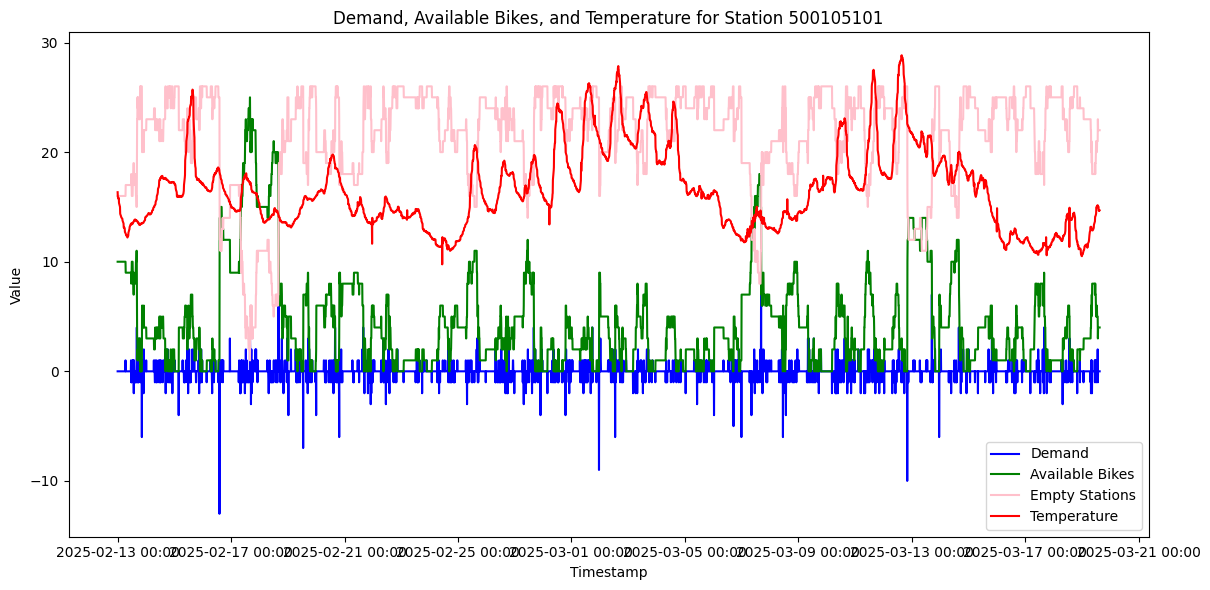

In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot demand, available bikes, and temperature for a specific station
station_id = sno  # Replace with a valid station ID
df_station = df_merged[df_merged["youbike_station_id"] == station_id]

plt.figure(figsize=(12, 6))

# Plot demand
plt.plot(df_station["timestamp"], df_station["demand"], label="Demand", color="blue")

# Plot available rent bikes
plt.plot(df_station["timestamp"], df_station["available_rent_bikes"], label="Available Bikes", color="green")

# Plot available rent bikes
plt.plot(df_station["timestamp"], df_station["available_return_bikes"], label="Empty Stations", color="pink")

# Plot temperature
plt.plot(df_station["timestamp"], df_station["temperature"], label="Temperature", color="red")

# Customize plot
plt.legend()
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.title(f"Demand, Available Bikes, and Temperature for Station {station_id}")
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.tight_layout()
# Set date formatter for x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

# Show the plot
plt.show()


/tmp/ipykernel_688039/572725454.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_youbike_station["timestamp"] = pd.to_datetime(df_youbike_station["timestamp"])


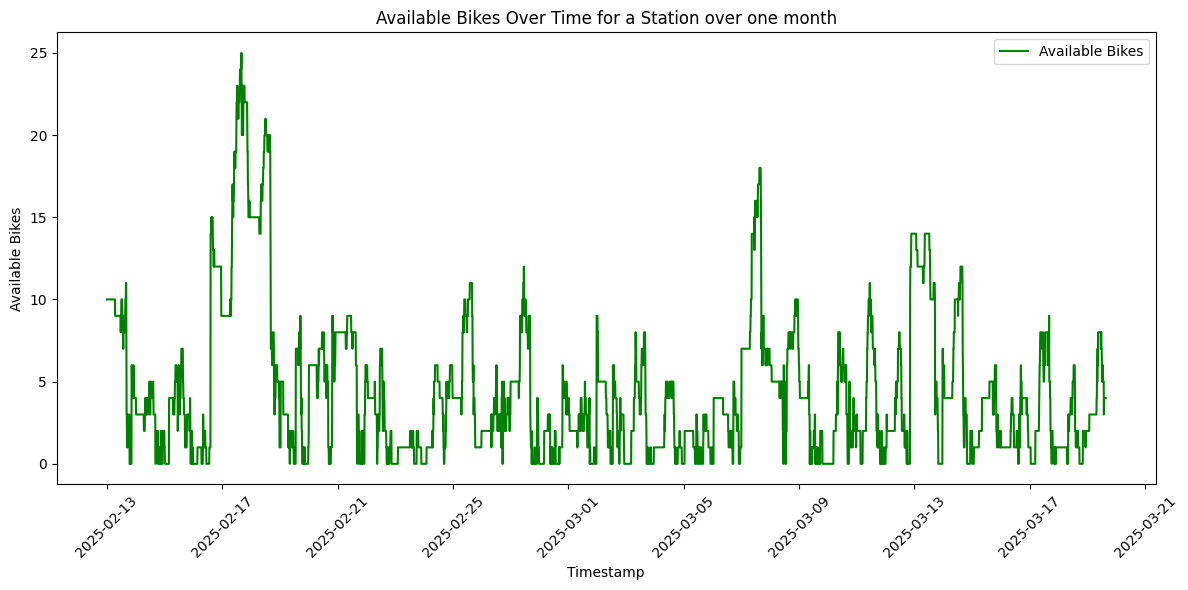

In [23]:
import matplotlib.pyplot as plt

# Filter the dataframe to the relevant station
station_id = sno  # Example station ID
df_youbike_station = df_youbike[df_youbike["youbike_station_id"] == station_id]

# Ensure timestamps are in datetime format
df_youbike_station["timestamp"] = pd.to_datetime(df_youbike_station["timestamp"])

# Plot the available_rent_bikes over time
plt.figure(figsize=(12, 6))
plt.plot(
    df_youbike_station["timestamp"],
    df_youbike_station["available_rent_bikes"],
    label="Available Bikes",
    color="green",
)

# Customize the plot
plt.legend()
plt.xlabel("Timestamp")
plt.ylabel("Available Bikes")
plt.title(f"Available Bikes Over Time for a Station over one month")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()

# Show the plot
plt.show()




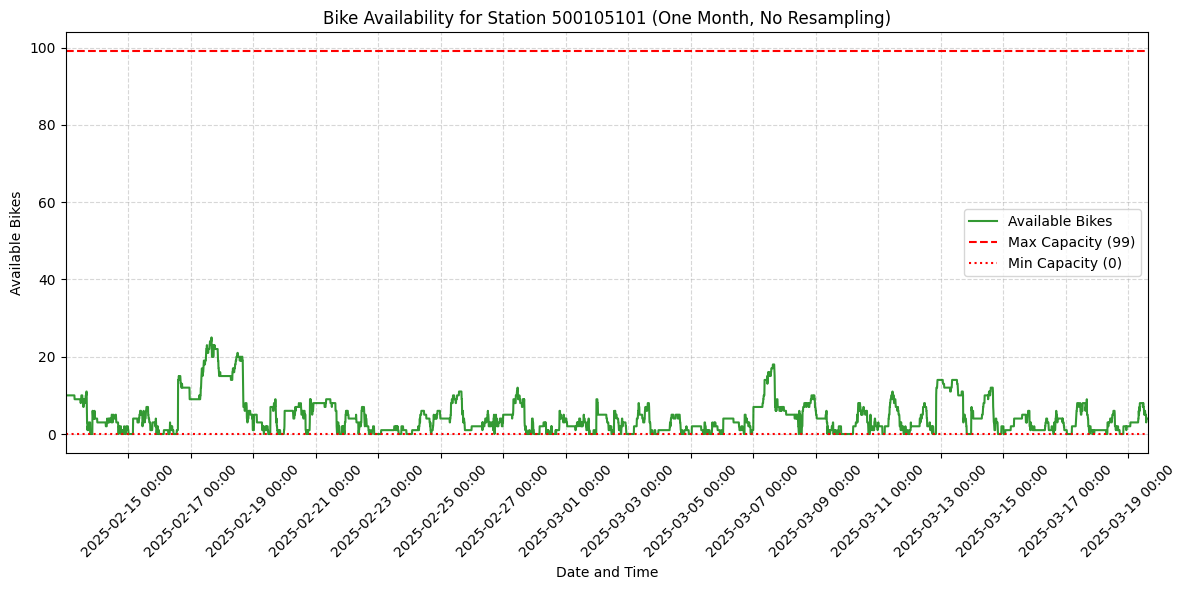

In [24]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert timestamps to datetime format
df_youbike["timestamp"] = pd.to_datetime(df_youbike["timestamp"])

# Filter the dataframe to the relevant station
station_id = sno  # Example station ID
df_youbike_station = df_youbike[df_youbike["youbike_station_id"] == station_id]

# Set timestamp as index
df_youbike_station = df_youbike_station.set_index("timestamp")

# Get the first and last timestamp in the dataset
start_time = df_youbike_station.index.min()
end_time = df_youbike_station.index.max()

# Calculate min available bikes in the dataset (without resampling)
min_capacity = df_youbike_station["available_rent_bikes"].min()

# Plot the original data without resampling
plt.figure(figsize=(12, 6))
plt.plot(
    df_youbike_station.index,
    df_youbike_station["available_rent_bikes"],
    label="Available Bikes",
    color="green",
    alpha=0.8
)

# Add horizontal red lines for max and min capacity
plt.axhline(y=99, color="red", linestyle="--", label="Max Capacity (99)")
plt.axhline(y=min_capacity, color="red", linestyle=":", label=f"Min Capacity ({min_capacity})")

# Customize x-axis format for better readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))  # Show full date and time
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))  # Show every 2 days

# Set x-axis limits dynamically based on the data
plt.xlim([start_time, end_time])

# Customize the plot
plt.legend()
plt.xlabel("Date and Time")
plt.ylabel("Available Bikes")
plt.title(f"Bike Availability for Station {station_id} (One Month, No Resampling)")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()


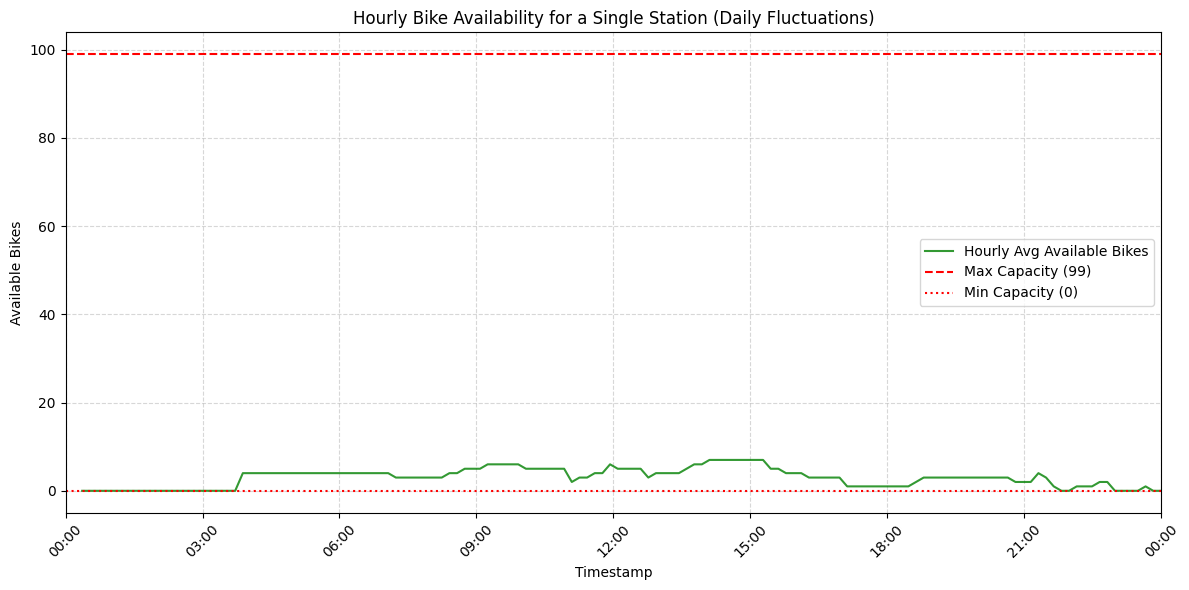

In [25]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert timestamps to datetime format
df_youbike["timestamp"] = pd.to_datetime(df_youbike["timestamp"])

# Filter the dataframe to the relevant station
station_id = sno  # Example station ID
df_youbike_station = df_youbike[df_youbike["youbike_station_id"] == station_id]

# Set timestamp as the index
df_youbike_station = df_youbike_station.set_index("timestamp")

# Define the slice for visualization
n = 24 * 6  # Adjust this based on your dataset
df_selected = df_youbike_station.iloc[2 * n : 3 * n]

# Get the minimum available_rent_bikes for this station in the selected range
min_capacity = df_selected["available_rent_bikes"].min()

# Plot the bike availability
plt.figure(figsize=(12, 6))
plt.plot(
    df_selected.index,
    df_selected["available_rent_bikes"],
    label="Hourly Avg Available Bikes",
    color="green",
    alpha=0.8
)

# Add horizontal red lines for max and min capacity
plt.axhline(y=99, color="red", linestyle="--", label="Max Capacity (99)")
plt.axhline(y=min_capacity, color="red", linestyle=":", label=f"Min Capacity ({min_capacity})")

# Ensure the x-axis starts at midnight and progresses hourly
date_of_interest = "2025-02-15"
midnight = pd.to_datetime(date_of_interest)
end_of_day = midnight + pd.Timedelta(days=1)

# Format x-axis to show time in HH:MM format (06:00, 09:00, etc.)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))  # Format as HH:MM
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=3))  # Show every 3 hours
plt.xlim([midnight, end_of_day])

# Customize the plot
plt.legend()
plt.xlabel("Timestamp")
plt.ylabel("Available Bikes")
plt.title(f"Hourly Bike Availability for a Single Station (Daily Fluctuations)")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()


In [26]:
df_merged.head()

,youbike_station_id,timestamp,available_rent_bikes,available_return_bikes,capacity,demand,temperature
0,500105101,2025-02-13 00:00:00,10,16.0,26.0,0,16.344444
1,500105101,2025-02-13 00:10:00,10,16.0,26.0,0,15.926316
2,500105101,2025-02-13 00:20:00,10,16.0,26.0,0,15.873684
3,500105101,2025-02-13 00:30:00,10,16.0,26.0,0,15.842105
4,500105101,2025-02-13 00:40:00,10,16.0,26.0,0,15.800000


In [27]:

# Optionally save the processed DataFrame
df_merged.to_csv(f"../data/prediction/processed_data_all_stations_weather_{station_id}.csv", index=False)
print("Processed data saved to 'processed_data.csv'")


Processed data saved to 'processed_data.csv'
